In [1]:
import pymssql
import pandas as pd
import configparser
import matplotlib.pyplot as plt
from psmpy import PsmPy
import numpy as np
from tqdm import tqdm

from dateutil.relativedelta import relativedelta

In [2]:
#Set up OMOP database connection

config = configparser.ConfigParser()
config.read('omop_db_config.ini')

db_host = config['database']['host']
db_user = config['database']['user']
db_password = config['database']['password']
db_name = config['database']['dbname']

sql_conn = pymssql.connect(db_host, db_user, db_password, db_name)
cursor = sql_conn.cursor(as_dict=True)

In [3]:
#Functions to query db
def get_data(sql_conn, query):
    cursor = sql_conn.cursor(as_dict=True)
    cursor.execute(query)
    results = cursor.fetchall()
    columns = [column[0] for column in cursor.description]
    df = pd.DataFrame(results, columns=columns)
    return df

def run_query(sql_conn, query):
    cursor = sql_conn.cursor(as_dict=True)
    cursor.execute(query)
    return None

# Motivation 1: Understanding Opioid Predispositions

## Defining 2 cohorts: opioid_dependent and not_opioid_dependent

In [4]:
#Select people that were prescribed the drug ids for hydrocode/oxycodone (specific list mentioned below)
# concept_name	concept_id
# dexbrompheniramine maleate 0.2 MG/ML / hydrocodone bitartrate 0.5 MG/ML / phenylephrine hydrochloride 1 MG/ML Oral Solution	40165568
# guaifenesin 20 MG/ML / hydrocodone bitartrate 0.5 MG/ML / pseudoephedrine hydrochloride 3 MG/ML Oral Solution	40165842
# oxycodone hydrochloride 1 MG/ML Oral Solution	40232700
# oxycodone hydrochloride 10 MG Oral Tablet	40232707
# oxycodone hydrochloride 15 MG Oral Tablet	40232717
# oxycodone hydrochloride 20 MG/ML Oral Solution	40232735
# oxycodone hydrochloride 30 MG Oral Tablet	40232745
# oxycodone hydrochloride 5 MG Oral Capsule	40232754
# oxycodone hydrochloride 5 MG Oral Tablet	40232756
# acetaminophen 750 MG / hydrocodone bitartrate 7.5 MG Oral Tablet	19133768
# hydrocodone bitartrate 7.5 MG / ibuprofen 200 MG Oral Tablet	40164715
# chlorpheniramine maleate 0.8 MG/ML / hydrocodone bitartrate 1 MG/ML Oral Solution	43525679
# Abuse-Deterrent 24 HR hydrocodone bitartrate 20 MG Extended Release Oral Tablet	45892337
# Abuse-Deterrent 24 HR hydrocodone bitartrate 30 MG Extended Release Oral Tablet	45892345
# Abuse-Deterrent 24 HR hydrocodone bitartrate 40 MG Extended Release Oral Tablet	45892351
# Abuse-Deterrent 24 HR hydrocodone bitartrate 60 MG Extended Release Oral Tablet	45892357
# acetaminophen 650 MG / oxycodone hydrochloride 10 MG Oral Tablet	40231855
# acetaminophen 325 MG / oxycodone hydrochloride 10 MG Oral Tablet	40231916
# acetaminophen 325 MG / oxycodone hydrochloride 5 MG Oral Tablet	40231925
# acetaminophen 325 MG / oxycodone hydrochloride 7.5 MG Oral Tablet	40231932
# Abuse-Deterrent 12 HR oxycodone hydrochloride 20 MG Extended Release Oral Tablet	1718691
# Abuse-Deterrent 12 HR oxycodone hydrochloride 40 MG Extended Release Oral Tablet	1718697
# Abuse-Deterrent 12 HR oxycodone hydrochloride 80 MG Extended Release Oral Tablet	1718699
# Abuse-Deterrent 12 HR oxycodone hydrochloride 15 MG Extended Release Oral Tablet	1718701
# Abuse-Deterrent 12 HR oxycodone hydrochloride 10 MG Extended Release Oral Tablet	1718702
# acetaminophen 500 MG / hydrocodone bitartrate 5 MG Oral Tablet	40162494
# acetaminophen 325 MG / hydrocodone bitartrate 10 MG Oral Tablet	40162511
# acetaminophen 325 MG / hydrocodone bitartrate 5 MG Oral Tablet	40162515
# acetaminophen 325 MG / hydrocodone bitartrate 7.5 MG Oral Tablet	40162522
# acetaminophen 21.7 MG/ML / hydrocodone bitartrate 0.5 MG/ML Oral Solution	40162563
# acetaminophen 21.7 MG/ML / hydrocodone bitartrate 0.67 MG/ML Oral Solution	40162566
# acetaminophen 33.3 MG/ML / hydrocodone bitartrate 0.5 MG/ML Oral Solution	40162587
# acetaminophen 300 MG / hydrocodone bitartrate 7.5 MG Oral Tablet	40162618

drop_table_query = """DROP TABLE IF EXISTS #opioid_presc_population"""

opioid_presc_pop_query = """
WITH PrescriptionFrequency AS (
    SELECT 
        [person_id],
        [drug_concept_id],
        COUNT(*) AS [prescription_frequency],
        ROW_NUMBER() OVER (PARTITION BY [person_id] ORDER BY COUNT(*) DESC) AS rn
    FROM [drug_exposure]
    WHERE [drug_concept_id] IN 
        (SELECT [concept_id]
         FROM [OMOP_DEID].[dbo].[concept]
         WHERE ([concept_name] LIKE '%oxycodone%' 
                OR [concept_name] LIKE '%hydrocodone%')
         AND [concept_class_id] = 'Clinical Drug'
         AND [domain_id] = 'Drug')
    GROUP BY [person_id], [drug_concept_id]
),
PrescriptionDetails AS (
    SELECT 
        [person_id],
        MIN([drug_exposure_start_date]) AS [first_presc_date],
        MAX([drug_exposure_start_date]) AS [last_presc_date],
        COUNT([visit_occurrence_id]) AS [n_visits]
    FROM [drug_exposure]
    WHERE [drug_concept_id] IN 
        (SELECT [concept_id]
         FROM [OMOP_DEID].[dbo].[concept]
         WHERE ([concept_name] LIKE '%oxycodone%' 
                OR [concept_name] LIKE '%hydrocodone%')
         AND [concept_class_id] = 'Clinical Drug'
         AND [domain_id] = 'Drug')
    GROUP BY [person_id]
    HAVING COUNT([visit_occurrence_id]) >= 2
)

SELECT 
    pd.[person_id],
    pd.[first_presc_date],
    pd.[last_presc_date],
    pd.[n_visits],
    pf.[drug_concept_id] AS [most_frequent_prescription]
INTO
    #opioid_presc_population
FROM 
    PrescriptionDetails pd
JOIN 
    PrescriptionFrequency pf
ON 
    pd.[person_id] = pf.[person_id]
WHERE 
    pf.rn = 1;
"""
run_query(sql_conn, drop_table_query)
run_query(sql_conn, opioid_presc_pop_query)

In [5]:
#Ensure that their records go back at least 6 months before their first prescription
query = """
SELECT o.*
FROM #opioid_presc_population o
WHERE EXISTS (
    SELECT 1
    FROM observation obs
    WHERE o.person_id = obs.person_id
    AND obs.observation_date <= DATEADD(MONTH, -6, o.first_presc_date)
)
"""

opioid_presc_population = get_data(sql_conn, query)

In [6]:
# Create a table of opioid dependent people
# concept_name	concept_id
# Opioid abuse with withdrawal	725281
# Opioid abuse with opioid-induced mood disorder	45566782
# Opioid dependence with opioid-induced psychotic disorder, unspecified	45566784
# Opioid dependence with other opioid-induced disorder	45566785
# Opioid abuse with unspecified opioid-induced disorder	45576500
# Opioid abuse, unspecified	44819555
# Opioid abuse with intoxication, uncomplicated	45542792
# Opioid abuse with opioid-induced sexual dysfunction	45542793
# Opioid abuse with other opioid-induced disorder	45542794
# Opioid dependence with intoxication, uncomplicated	45542795
# Opioid dependence with intoxication delirium	45542796
# Opioid abuse, in remission	44834602
# Opioid abuse, continuous	44822989
# Opioid dependence with opioid-induced sleep disorder	45533067
# Opioid dependence with opioid-induced psychotic disorder with hallucinations	45591090
# Opioid dependence with opioid-induced sexual dysfunction	45591091
# Opioid abuse with intoxication delirium	45571712
# Opioid abuse	44827668
# Opioid abuse, episodic	44829939
# Opioid dependence with intoxication, unspecified	45557159
# Opioid dependence with withdrawal	45557160
# Opioid abuse with intoxication, unspecified	45581409
# Opioid dependence, uncomplicated	45586193
# Opioid abuse, in remission	1326498
# Opioid abuse with opioid-induced psychotic disorder, unspecified	45562007
# Opioid dependence with opioid-induced psychotic disorder with delusions	45595854
# Opioid abuse with intoxication with perceptual disturbance	45600697
# Opioid abuse, uncomplicated	45605458
# Opioid dependence, in remission	45605459
# Opioid dependence with opioid-induced mood disorder	45605460
# Opioid dependence with unspecified opioid-induced disorder	45605461

opioid_dep_pop_query = """
WITH ConditionFrequency AS (
    SELECT 
        [person_id],
        [condition_concept_id],
        COUNT(*) AS [condition_frequency],
        ROW_NUMBER() OVER (PARTITION BY [person_id] ORDER BY COUNT(*) DESC) AS rn
    FROM [condition_occurrence]
    WHERE [condition_concept_id] IN 
        (SELECT [concept_id]
         FROM [OMOP_DEID].[dbo].[concept]
         WHERE ([concept_name] LIKE '%opioid dependence%'
         OR [concept_name] LIKE '%opioid abuse%')
         AND [domain_id] = 'Condition')
    GROUP BY [person_id], [condition_concept_id]
)
, DiagnosisDetails AS (
    SELECT 
        [person_id],
        MIN([condition_start_date]) AS [first_diagnosis_date],
        MAX([condition_start_date]) AS [last_diagnosis_date],
        COUNT([visit_occurrence_id]) AS [n_visits]
    FROM [condition_occurrence]
    WHERE [condition_concept_id] IN 
        (SELECT [concept_id]
         FROM [OMOP_DEID].[dbo].[concept]
         WHERE ([concept_name] LIKE '%opioid dependence%'
         OR [concept_name] LIKE '%opioid abuse%')
         AND [domain_id] = 'Condition')
    GROUP BY [person_id]
)
SELECT 
    d.[person_id],
    d.[first_diagnosis_date],
    d.[last_diagnosis_date],
    d.[n_visits],
    cf.[condition_concept_id] AS [most_frequent_condition]
FROM 
    DiagnosisDetails d
JOIN 
    ConditionFrequency cf
ON 
    d.[person_id] = cf.[person_id]
WHERE 
    cf.rn = 1
    AND d.[n_visits] >= 2;
"""
opioid_dep_population = get_data(sql_conn, opioid_dep_pop_query)

In [7]:
# Add a column to opioid_presc_population to say if they are addicted, then split into 2 tables

#TODO: Should I use first or last presc date to add 6 months to before seeing if a diagnosis appears? Using first rn.

merged_opioid = pd.merge(opioid_presc_population, opioid_dep_population[['person_id', 'first_diagnosis_date', 'most_frequent_condition']], 
                     on='person_id', how='left')

merged_opioid['dependent'] = (merged_opioid['first_diagnosis_date'] >= merged_opioid['first_presc_date'] + relativedelta(months=6))

merged_opioid['most_frequent_condition'] = merged_opioid['most_frequent_condition'].fillna(0).astype('int64')
op_addicted = merged_opioid[merged_opioid['dependent']]

#Filters for people who had opioid dependence diagnosed before or up to 6 months after their first prescription
not_op_addicted = merged_opioid[merged_opioid['dependent'] == False]
not_op_addicted = not_op_addicted[not_op_addicted['first_diagnosis_date'].isna()]

In [8]:
#Perform filters on not_opioid_dependent population: ensure they have a visit after 6 months

#Create Table with Filtered Opioid patient IDs
not_op_addicted_ids = not_op_addicted.person_id.to_list()
not_op_addicted_ids = '), ('.join([str(subject_ids) for subject_ids in not_op_addicted_ids])
not_op_addicted_ids = '(' + not_op_addicted_ids + ')'
not_op_addicted_ids = not_op_addicted_ids.split(', ')

query = f"""
DROP TABLE IF EXISTS #not_op_patient_ids;
CREATE TABLE #not_op_patient_ids (cond_id INT);
"""

for subject_id in not_op_addicted_ids:
    query += f"""
INSERT INTO #not_op_patient_ids (cond_id)
VALUES {subject_id};
"""
run_query(sql_conn, query)

#choose visit ocurrences that match the ids of not_op_addicted population
visits_not_op_query = """
    SELECT DISTINCT [visit_start_date],
	[person_id]
  FROM [OMOP_DEID].[dbo].[visit_occurrence]
  WHERE [person_id] IN (
    SELECT cond_id FROM #not_op_patient_ids
  )
"""
visits_not_op = get_data(sql_conn, visits_not_op_query)


#Only keep the records that have a visit ocurrence >= 6 months from the first prescription
merged_not_op = not_op_addicted.merge(visits_not_op, on = 'person_id', how = 'left')
filtered_merged_not_op = merged_not_op[merged_not_op['visit_start_date'] >= merged_not_op['first_presc_date'] + relativedelta(months=6)]['person_id'].unique()
not_op_addicted = not_op_addicted[not_op_addicted['person_id'].isin(filtered_merged_not_op)]

In [9]:
not_op_addicted.head(5)

,person_id,first_presc_date,last_presc_date,n_visits,most_frequent_prescription,first_diagnosis_date,most_frequent_condition,dependent
0,2577690,2012-10-04,2013-09-17,9,40162511,NaN,0,False
1,1654721,2016-03-17,2019-02-09,7,40232756,NaN,0,False
2,280907,2016-08-29,2016-09-03,23,40232756,NaN,0,False
3,1087526,2014-04-11,2014-04-18,19,40232756,NaN,0,False
4,4087605,2019-11-29,2019-12-06,27,40232756,NaN,0,False


In [10]:
op_addicted.head(5)

,person_id,first_presc_date,last_presc_date,n_visits,most_frequent_prescription,first_diagnosis_date,most_frequent_condition,dependent
261,4720971,2015-11-04,2020-02-14,76,40162511,2019-07-05,44822989,True
475,2514155,2014-07-20,2014-07-20,2,40232756,2015-06-23,44819555,True
744,3365577,2016-08-26,2016-08-26,3,40162515,2019-06-23,44819555,True
842,4360265,2014-06-02,2014-07-27,124,40232756,2015-02-17,45586193,True
926,916377,2014-05-09,2019-01-01,4,40162515,2019-02-03,45586193,True


## Add Age and Sex Data for Propensity Score Matching

In [11]:
#Create Table with addicted patient IDs
op_addicted_ids = op_addicted.person_id.to_list()
op_addicted_ids = '), ('.join([str(subject_ids) for subject_ids in op_addicted_ids])
op_addicted_ids = '(' + op_addicted_ids + ')'
op_addicted_ids = op_addicted_ids.split(', ')

query_op_ids = f"""
DROP TABLE IF EXISTS #op_addicted_patient_ids;
CREATE TABLE #op_addicted_patient_ids (person_id INT);
"""

for subject_id in op_addicted_ids:
    query_op_ids += f"""
INSERT INTO #op_addicted_patient_ids (person_id)
VALUES {subject_id};
"""
    
run_query(sql_conn, query_op_ids)

#Add age and sex info to table
op_bio_query = """
SELECT
    p.person_id, 
    p.gender_source_value, 
    2024 - p.year_of_birth AS age, 
    p.ethnicity_source_value

FROM
    #op_addicted_patient_ids op
    
    JOIN [OMOP_DEID].[dbo].[person] p
        ON op.person_id = p.person_id
"""

op_addicted = op_addicted.merge(get_data(sql_conn, op_bio_query), on = 'person_id', how = 'left')

In [12]:
#Create Bio table for non-addicted population
not_op_addicted_ids = not_op_addicted.person_id.to_list()
not_op_addicted_ids = '), ('.join([str(subject_ids) for subject_ids in not_op_addicted_ids])
not_op_addicted_ids = '(' + not_op_addicted_ids + ')'
not_op_addicted_ids = not_op_addicted_ids.split(', ')

query_not_op_ids = f"""
DROP TABLE IF EXISTS #not_op_addicted_patient_ids;
CREATE TABLE #not_op_addicted_patient_ids (person_id INT);
"""

for subject_id in not_op_addicted_ids:
    query_not_op_ids += f"""
INSERT INTO #not_op_addicted_patient_ids (person_id)
VALUES {subject_id};
"""
    
run_query(sql_conn, query_not_op_ids)

#Add age and sex info to table
n_op_bio_query = """
SELECT
    p.person_id, p.gender_source_value, 
    2024 - p.year_of_birth AS age, 
    p.ethnicity_source_value

FROM
    #not_op_addicted_patient_ids n_op
    
    JOIN [OMOP_DEID].[dbo].[person] p
        ON n_op.person_id = p.person_id
"""

not_op_addicted = not_op_addicted.merge(get_data(sql_conn, n_op_bio_query), on = 'person_id', how = 'left')

In [13]:
not_op_addicted.head()

,person_id,first_presc_date,last_presc_date,n_visits,most_frequent_prescription,first_diagnosis_date,most_frequent_condition,dependent,gender_source_value,age,ethnicity_source_value
0,2577690,2012-10-04,2013-09-17,9,40162511,NaN,0,False,Male,72,Not Hispanic or Latino
1,1654721,2016-03-17,2019-02-09,7,40232756,NaN,0,False,Female,32,Not Hispanic or Latino
2,280907,2016-08-29,2016-09-03,23,40232756,NaN,0,False,Male,66,Not Hispanic or Latino
3,1087526,2014-04-11,2014-04-18,19,40232756,NaN,0,False,Female,81,Not Hispanic or Latino
4,4087605,2019-11-29,2019-12-06,27,40232756,NaN,0,False,Male,77,Not Hispanic or Latino


# Perform Propensity Score Matching on Age, Sex, Length of Prescription

In [14]:
full_bio_cohort = pd.concat([op_addicted, not_op_addicted], axis=0, ignore_index=True)
full_bio_cohort['presc_length'] = full_bio_cohort.apply(
    lambda r: int((r['last_presc_date'] - r['first_presc_date']).days), axis=1
)
full_bio_cohort['gender_source_value'] = full_bio_cohort['gender_source_value'].map({'Male': 0, 'Female': 1}).fillna(2).astype(int)

# Create an instance of PsmPy
prop_sm = PsmPy(full_bio_cohort[['person_id', 'gender_source_value', 'age', 'dependent', 'most_frequent_prescription', 'presc_length']], treatment='dependent', indx='person_id')

# Calculate the propensity scores based on sex and age
prop_sm.logistic_ps(balance=True)

# Perform matching, with a ratio of 15 controls to each test subject
prop_sm.knn_matched_12n(matcher='propensity_logit', how_many=15)

#List of final ids for cohort, after matching
final_cohort_ids = prop_sm.matched_ids.values.ravel()

In [15]:
prop_sm.matched_ids

,person_id,largerclass_0group,largerclass_1group,largerclass_2group,largerclass_3group,largerclass_4group,largerclass_5group,largerclass_6group,largerclass_7group,largerclass_8group,largerclass_9group,largerclass_10group,largerclass_11group,largerclass_12group,largerclass_13group,largerclass_14group
0,4720971,4337859,5580471,4604823,2200970,4788553,320833,1483734,3900948,1877782,4677890,3913406,2294328,266382,4554481,4611817
1,2514155,424501,4828539,3117595,2386729,4192745,806534,2197622,2636717,3936412,4210744,1720262,5208490,1301036,2344121,1132057
2,3365577,3168269,5170131,261004,1595020,689905,2925061,921420,1411833,2178294,5432610,910529,5386053,1614197,5286642,1625080
3,4360265,2635636,1863558,5188941,3553110,5329988,2730796,5567502,3694465,2470687,5315474,1699625,35090,2703326,3017318,4059
4,916377,2033026,2617796,3132098,3337630,1785314,3417224,4109820,3904460,5014359,5309931,499869,1821666,2835533,3768029,3648309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374,1166941,5335667,3699775,2194824,1307477,2878774,1149596,2520016,634380,4831631,1302639,4947262,681871,5308669,4717062,2880876
375,3959561,5088327,1160921,961099,3821591,1545584,5695826,1504153,3869984,2882240,4305991,182896,3004158,125377,1411542,3262449
376,4474130,5718607,2622353,1137933,5290467,1731522,66245,2004849,4707993,1424827,4364624,769565,1880471,2814486,5692808,582848
377,2125694,472865,2812726,4318968,3054859,3515899,3036260,712969,2048330,421864,3419090,3586489,4503219,5301509,5559986,2278863


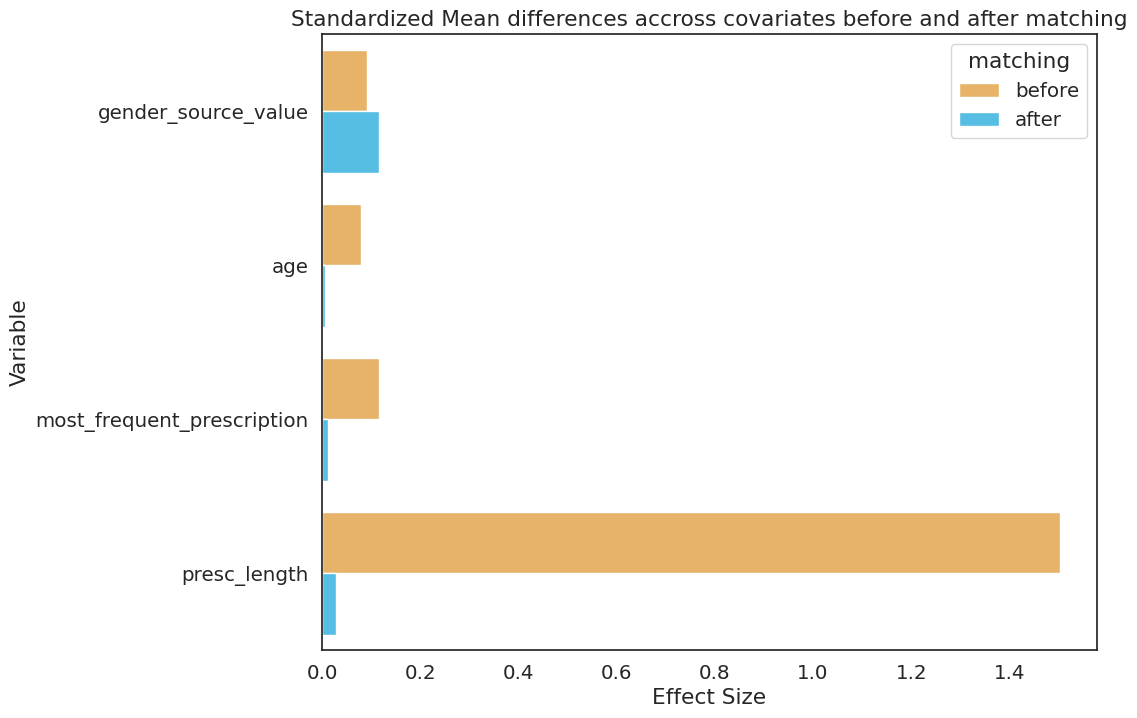

In [16]:
prop_sm.effect_size_plot()

# Create MetaTables for Each ID After PSM

In [17]:
#Change not_op and full_bio_cohort to reflect the PSM matching
not_op_addicted = not_op_addicted[not_op_addicted['person_id'].isin(final_cohort_ids)]
full_bio_cohort = full_bio_cohort[full_bio_cohort['person_id'].isin(final_cohort_ids)]
full_bio_cohort['cutoff_date'] = full_bio_cohort['first_presc_date'] + relativedelta(months=6)

In [18]:
# Create a SQL table with the full cohort ids + date 6 months after their prescription (cut-off after which dependencies can be diagnosed). This will be used to find relevant concepts and encode them for SPOKE
query_EHR_concept_ref = f"""
DROP TABLE IF EXISTS #ehr_concept_ref;
CREATE TABLE #ehr_concept_ref (person_id INT, cutoff_date DATE);
"""

for index, row in full_bio_cohort.iterrows():
    query_EHR_concept_ref += f"""
INSERT INTO #ehr_concept_ref (person_id, cutoff_date)
VALUES ({row['person_id']}, '{row['cutoff_date']}');
"""

run_query(sql_conn, query_EHR_concept_ref)

In [19]:
#Creating concept metatables. Leaving out measurement for now, since unsure how to map it into SPOKE

query_person_mt = """
SELECT p.[person_id]
    ,[race_concept_id]
    ,[ethnicity_concept_id]
FROM [OMOP_DEID].[dbo].[person] p
JOIN #ehr_concept_ref ref ON p.person_id = ref.person_id;
"""
person_mt = get_data(sql_conn, query_person_mt).drop_duplicates()
person_mt = pd.melt(person_mt, id_vars=['person_id'], 
                    value_vars=['race_concept_id', 'ethnicity_concept_id'],
                    value_name='concept').drop(['variable'], axis = 1)

query_drugs_mt = """
SELECT d.[person_id]
    ,[drug_concept_id] AS concept
FROM [OMOP_DEID].[dbo].[drug_exposure] d
JOIN #ehr_concept_ref ref ON d.person_id = ref.person_id
WHERE d.drug_exposure_start_date < ref.cutoff_date;
"""
drugs_mt = get_data(sql_conn, query_drugs_mt).drop_duplicates()

query_conditions_mt = """
SELECT c.[person_id]
    ,[condition_concept_id] AS concept
FROM [OMOP_DEID].[dbo].[condition_occurrence] c
JOIN #ehr_concept_ref ref ON c.person_id = ref.person_id
WHERE c.condition_start_date < ref.cutoff_date;
"""
conditions_mt = get_data(sql_conn, query_conditions_mt).drop_duplicates()

# Translate Concepts to SPOKE Codes, Formatting for SEPs

## @TODO add measurements to this

In [20]:
#Translating conditions
disease_annotation = pd.read_csv('data/omop2spoke.tsv', sep = '\t')
disease_annotation.rename(columns={'OMOP': 'condition_concept_id'}, inplace=True)
disease_annotation.rename(columns={'SPOKE': 'spoke_concept_id'}, inplace=True)

omop_to_spoke_dict = dict(zip(disease_annotation['condition_concept_id'], disease_annotation['spoke_concept_id']))

conditions_mt['spoke_code'] = conditions_mt['concept'].map(omop_to_spoke_dict)

#Translating Drugs
drug_annotation = pd.read_csv('data/drug2spoke.tsv', sep = '\t')
drug_annotation.rename(columns={'OMOP': 'condition_concept_id'}, inplace=True)
drug_annotation.rename(columns={'SPOKE': 'spoke_concept_id'}, inplace=True)

omop_to_spoke_dict = dict(zip(drug_annotation['condition_concept_id'], drug_annotation['spoke_concept_id']))

drugs_mt['spoke_code'] = drugs_mt['concept'].map(omop_to_spoke_dict)

In [21]:
#Can see which codes were not matched to a SPOKE node

# conditions_mt[conditions_mt['spoke_code'].isna()]['concept'].tolist()
# drugs_mt[drugs_mt['spoke_code'].isna()]['concept'].tolist()

In [22]:
#One hot encode all the concepts

#Drop anything that wasn't mapped to SPOKE
concepts_ehr = pd.concat([person_mt, drugs_mt, conditions_mt], ignore_index=True)
concepts_ehr = concepts_ehr[concepts_ehr['spoke_code'].notna()][['person_id', 'spoke_code']]

#Drop repeat spoke codes (multiple OMOP map to single SPOKE)
concepts_ehr = concepts_ehr[['person_id', 'spoke_code']].drop_duplicates()

# Create dummy variables
dummies = pd.get_dummies(concepts_ehr['spoke_code'])

# Concatenate with the original DataFrame
df_with_dummies = pd.concat([concepts_ehr[['person_id']], dummies], axis=1)

# Group by 'person_id' and sum up the dummy columns to avoid multiple rows for the same person
#doing this in chunks since takes too much memory to use groupby directly
# Assuming df_with_dummies is your original DataFrame
chunk_size = 10000
results = []

# Process the DataFrame in chunks
num_chunks = (len(df_with_dummies) // chunk_size) + 1  # Calculate total number of chunks
for start in tqdm(range(0, len(df_with_dummies), chunk_size)):
    chunk = df_with_dummies.iloc[start:start + chunk_size]
    
    # Perform the groupby and aggregation for the current chunk
    chunk_result = chunk.groupby('person_id').sum().reset_index()
    
    # Append the chunk result to the results list
    results.append(chunk_result)
    
# Concatenate all chunk results into a final DataFrame
final_df = pd.concat(results, ignore_index=True)

# Final aggregation to ensure no duplicates (in case of overlapping person_ids across chunks)
final_df = final_df.groupby('person_id').sum().reset_index()

100%|██████████| 76/76 [02:56<00:00,  2.32s/it]


In [23]:
final_df

,person_id,C0000731,C0000735,C0000737,C0000768,C0000786,C0000814,C0000833,C0001361,C0001511,...,DOID:9965,DOID:9969,DOID:997,DOID:9970,DOID:9971,DOID:9972,DOID:9975,DOID:9988,DOID:9993,DOID:9997
0,4059,0,0,0,0,0,0,0,0,0,...,0,0,0,4,0,0,0,0,0,0
1,4502,0,0,3,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0
2,4557,0,0,0,0,0,0,0,0,0,...,0,0,0,10,0,0,0,0,0,0
3,4575,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5127,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6059,5733632,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0
6060,5734285,0,0,4,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0
6061,5735687,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6062,5736459,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [201]:
final_df.to_feather("data/opioid_concept_map.feather")

In [204]:
full_bio_cohort.to_feather('data/opioid_cohort_details.feather')

In [ ]:
#Databases to merge for SPOKE access: person, measurement, drug_exposure, condition_ocurrence

In [49]:
#Find all events where alcohol dependence was diagnosed— Includes these conditions
# concept_name	concept_id
# Other and unspecified alcohol dependence, continuous	44825305
# Alcohol dependence with alcohol-induced mood disorder	45562002
# Alcohol dependence with alcohol-induced psychotic disorder with delusions	45562003
# Other and unspecified alcohol dependence	44819550
# Other and unspecified alcohol dependence, episodic	44819551
# Alcohol dependence, in remission	45581405
# Alcohol dependence with withdrawal delirium	45552431
# Other and unspecified alcohol dependence, unspecified	44831100
# Alcohol dependence with withdrawal with perceptual disturbance	45566775
# Alcohol dependence with alcohol-induced persisting dementia	45566776
# Alcohol dependence with alcohol-induced anxiety disorder	45566777
# Alcohol dependence with intoxication, unspecified	45538007
# Alcohol dependence with unspecified alcohol-induced disorder	45591084
# Other and unspecified alcohol dependence, in remission	44828838
# Alcohol dependence with alcohol-induced persisting amnestic disorder	45595847
# Alcohol dependence with alcohol-induced sleep disorder	45600696
# Alcohol dependence with alcohol-induced psychotic disorder with hallucinations	45557155
# Alcohol dependence syndrome	44832244
# Alcohol dependence with withdrawal, unspecified	45533065
# Alcohol dependence with alcohol-induced psychotic disorder, unspecified	45571708
# Alcohol dependence with other alcohol-induced disorder	45571709
# Alcohol dependence, uncomplicated	45586187
# Alcohol dependence with intoxication, uncomplicated	45586188
# Alcohol dependence with intoxication delirium	45586189
# Alcohol dependence with withdrawal, uncomplicated	45586190

alc_dep_pop_query = f"""

WITH ConditionFrequency AS (
    SELECT 
        [person_id],
        [condition_concept_id],
        COUNT(*) AS [condition_frequency],
        ROW_NUMBER() OVER (PARTITION BY [person_id] ORDER BY COUNT(*) DESC) AS rn
    FROM [condition_occurrence]
    WHERE [condition_concept_id] IN 
        (SELECT [concept_id]
         FROM [OMOP_DEID].[dbo].[concept]
         WHERE [concept_name] LIKE '%alcohol dependence%'
         AND [domain_id] = 'Condition')
    GROUP BY [person_id], [condition_concept_id]
)
, DiagnosisDetails AS (
    SELECT 
        [person_id],
        MIN([condition_start_date]) AS [first_diagnosis_date],
        MAX([condition_start_date]) AS [last_diagnosis_date],
        COUNT([visit_occurrence_id]) AS [n_visits]
    FROM [condition_occurrence]
    WHERE [condition_concept_id] IN 
        (SELECT [concept_id]
         FROM [OMOP_DEID].[dbo].[concept]
         WHERE [concept_name] LIKE '%alcohol dependence%'
         AND [domain_id] = 'Condition')
    GROUP BY [person_id]
)
SELECT 
    d.[person_id],
    d.[first_diagnosis_date],
    d.[last_diagnosis_date],
    d.[n_visits],
    cf.[condition_concept_id] AS [most_frequent_condition]
FROM 
    DiagnosisDetails d
JOIN 
    ConditionFrequency cf
ON 
    d.[person_id] = cf.[person_id]
WHERE 
    cf.rn = 1
    AND d.[n_visits] >= 2;
"""
alc_dep_population = get_data(sql_conn, alc_dep_pop_query)